In [1]:
import os
import sys
import math
import operator
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import gridmap_config as c

from IPython.display import display, HTML
from tabulate import tabulate
from shapely.geometry import Polygon, Point
from math import sqrt
from shapely.affinity import translate

In [2]:
# Attribute names to add to geodataframe during processing
tile_id = 'tile_id'
admin_id = 'admin_id'
admin_id_admin = 'admin_id_admin'
admin_id_tile = 'admin_id_tile'
jo_tile = 'join_order_tile'
jo_admin = 'join_order_admin'

# Variable names for input data

## Kenya
# polys = c.kenya_counties_msSimplified
# admin_name_col = 'CID'
# keep_flds = ['County', 'CID']
# epsg = 32662

## USA
# polys = c.USA_extraSimp
# admin_name_col = 'HASC_1'
# keep_flds = ['NAME_1', admin_id]
# epsg = 5070

## India
polys = c.india_simp
admin_name_col = 'AREA_NAME'
keep_flds = ['AREA_NAME', admin_id]
epsg = 4240

In [3]:
os.path.isfile(polys)

True

In [4]:
def read_file_and_attempt_projection(file, epsg_code):
    try:
        gdf = gpd.read_file(file).to_crs({'init': 'epsg:{}'.format(epsg_code)})
        print('Data projected to EPSG code: {}'.format(epsg_code))
    except:
        gdf = gpd.read_file(file)
        print('*** Failed to project to EPSG code: {} \
              \n*** Data read in with this CRS: {}'.format(epsg_code, gdf.crs))
    return gdf

In [5]:
admin = read_file_and_attempt_projection(polys, epsg)
#admin[admin_id] = admin[admin_name_col].str.split('.').str[1] #For USA
admin[admin_id] = admin[admin_name_col].str.split(' ').str[0]
admin = admin.sort_values(by=admin_name_col).reset_index(drop=True)
admin = admin.rename(columns={'geometry': 'geom_poly'}).set_geometry('geom_poly')
keep_flds.append(admin.geometry.name)
del_flds = [x for x in list(admin) if x not in keep_flds]
admin.drop(columns=del_flds, inplace=True)
print(display(HTML(admin.to_html())))

Data projected to EPSG code: 4240


,AREA_NAME,geom_poly,admin_id
0,ANDAMAN AND NICOBAR ISLANDS,(POLYGON ((93.85044516854998 7.238182957145647...,ANDAMAN
1,ANDHRA PRADESH,"(POLYGON ((82.3330102843619 16.72361799752658,...",ANDHRA
2,ARUNÄCHAL PRADESH,"POLYGON ((95.24375459321844 26.68200408915338,...",ARUNÄCHAL
3,ASSAM,"POLYGON ((95.19836969571003 27.04253437896892,...",ASSAM
4,BIHÄR,"POLYGON ((88.10711142222728 26.54031034722179,...",BIHÄR
5,CHANDÄªGARH,"POLYGON ((76.82838439037184 30.76397306268315,...",CHANDÄªGARH
6,CHHATTÄªSGARH,"POLYGON ((84.00370594246664 22.52015434613474,...",CHHATTÄªSGARH
7,DAMÄN AND DIU,(POLYGON ((72.85976200536028 20.47008277011346...,DAMÄN
8,DELHI,"POLYGON ((77.187115335638 28.86679668685893, 7...",DELHI
9,DÄDRA AND NAGAR HAVELI,"POLYGON ((73.21599106679206 20.12108906106726,...",DÄDRA


None


In [6]:
def display_point_labels(gdf, label_col, fs=10, c='blue', angle=0):
    texts = []
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf[label_col]):
        texts.append(plt.text(x, y, label, fontsize=fs, color=c, rotation=angle, 
                              horizontalalignment='center', verticalalignment='center'))

def add_centroid_geom(gdf):
    gdf['geom_centroid'] = gdf.centroid
    return gdf

def add_convexhull_geom(gdf):
    gdf['geom_convexhull'] = gdf.convex_hull
    return gdf

def dissolve_polygons(gdf):
    gdf['dissolve_col'] = 1
    gdf_dissolve = gdf.dissolve(by='dissolve_col')
    #gdf_dissolve['geom_exterior'] = Polygon(gdf_dissolve.exterior[1])
    #gdf_dissolve = gdf_dissolve.set_geometry('geom_exterior')
    gdf_dissolve['geom_centroid'] = gdf_dissolve.centroid
    return gdf_dissolve.reset_index(drop=True)

admin = add_centroid_geom(admin)
admin = add_convexhull_geom(admin)
admin_hulls_dissolved = dissolve_polygons(admin.set_geometry('geom_convexhull'))

print(display(HTML(admin_hulls_dissolved.to_html())))

,geom_convexhull,AREA_NAME,geom_poly,admin_id,geom_centroid
0,(POLYGON ((73.04897793823524 8.264839153846337...,ANDAMAN AND NICOBAR ISLANDS,(POLYGON ((93.85044516854998 7.238182957145647...,ANDAMAN,POINT (80.08771245598044 22.67141701398852)


None


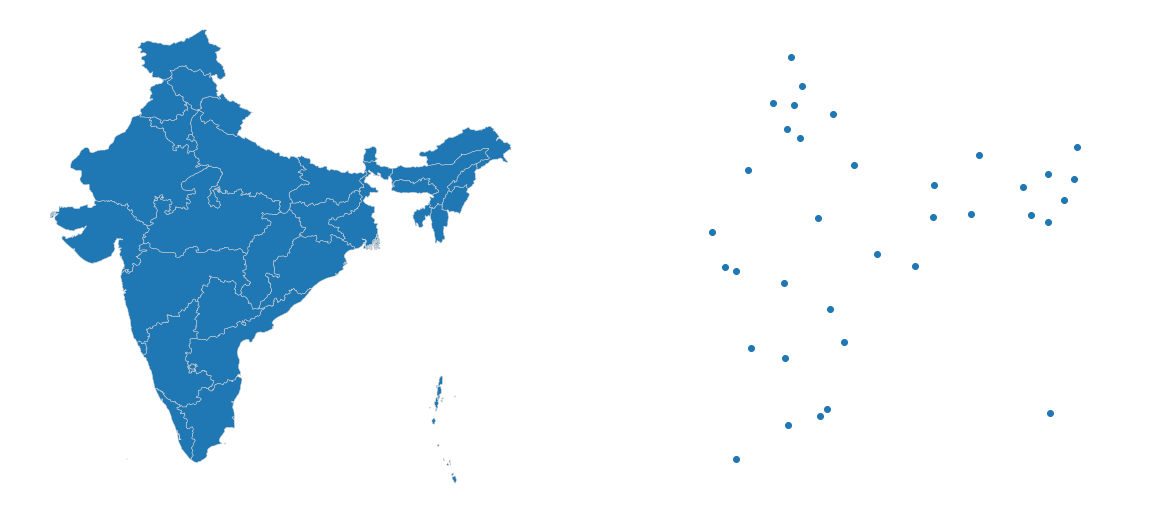

In [7]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, edgecolor='lightgrey')

# Plot on axis 2 (right)
ax2.set_axis_off()
admin.set_geometry('geom_centroid').plot(ax=ax2)

plt.show()

/anaconda3/envs/hexgrid/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


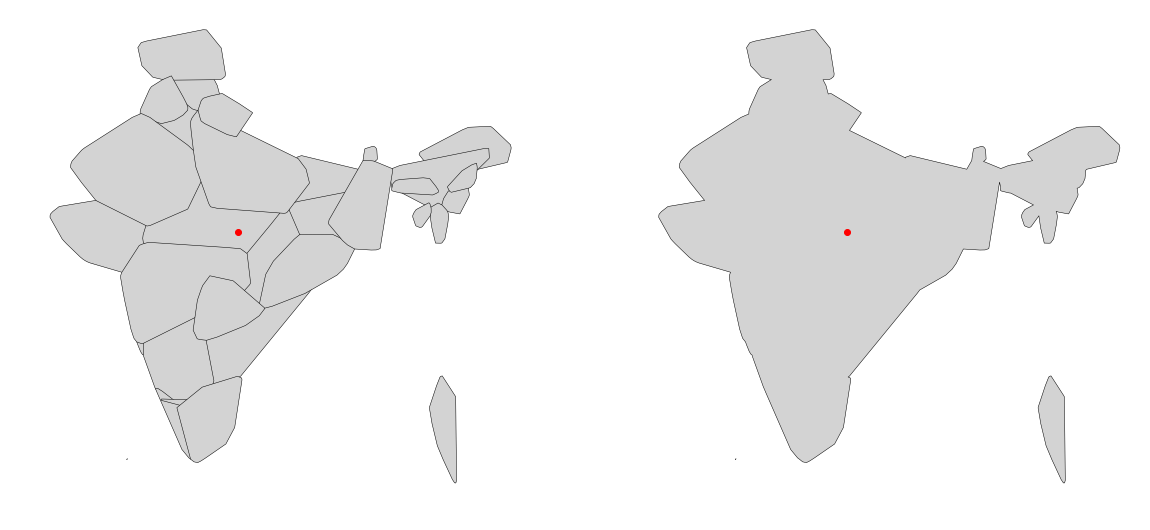

In [8]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_convexhull').plot(ax=ax1, linewidth=0.5, edgecolor='black', color='lightgrey')
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax1, color='red')

# Plot on axis 2 (right)
ax2.set_axis_off()
admin_hulls_dissolved.plot(ax=ax2, linewidth=0.5, edgecolor='black', color='lightgrey')
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax2, color='red')
admin.loc[admin[admin_id] == 'ME'].set_geometry('geom_centroid').plot(ax=ax2, color='black')

plt.show()

In [9]:
def round_dict_vals(dictionary, places=10):
    for k, v in dictionary.items():
        dictionary[k] = float(round(dictionary[k], places))
    return dictionary

def get_bounding_coordinates(gpd, round_nums=True):
    tb = gpd.total_bounds
    total_bounds = {'minx': tb[0],
                    'miny': tb[1],
                    'maxx': tb[2],
                    'maxy': tb[3],
                    'rangex': abs(tb[0] - tb[2]),
                    'rangey': abs(tb[1] - tb[3])}
    if round_nums:
        total_bounds = round_dict_vals(total_bounds)
    
    return total_bounds

def build_bounding_polygon(extent, crs):
    BL = (extent['minx'], extent['miny'])
    BR = (extent['maxx'], extent['miny'])
    TR = (extent['maxx'], extent['maxy'])
    TL = (extent['minx'], extent['maxy'])
    corners = [BL, BR, TR, TL]
    rectangle = gpd.GeoDataFrame(pd.DataFrame({'geometry': [Polygon(corners)]}), geometry='geometry', crs=crs)
    
    return rectangle
    
bbox = get_bounding_coordinates(admin.set_geometry('geom_poly'))
bbox_gdf = build_bounding_polygon(bbox, admin.crs)
bbox

{'minx': 68.1863092165,
 'miny': 6.7776693659,
 'maxx': 97.3974360549,
 'maxy': 35.4964329873,
 'rangex': 29.2111268384,
 'rangey': 28.7187636214}

In [10]:
def displace_vertex(x, y, length, angle):
    '''
    calculates new point up to a given distance away
    from original point. All values should be provided
    in meters

    point = (x,y)
    '''
    #The number pi
    PI = 3.1415926535

    #Convert the random angle from degrees to radians
    angle_radian = (angle) * (PI/180)

    #Generate the offset by applying trig formulas (law of cosines) 
    #using the distance as the hypotenuse solving for the other sides
    xOffset = math.sin(angle_radian) * length
    yOffset = math.cos(angle_radian) * length

    #Add the offset to the orginal coordinate
    new_x = x + xOffset
    new_y = y + yOffset

    return (new_x, new_y) 

def build_hexagon(x, y, length, bearing):
    pts = [(x,y)]
    
    for pt in range(0,5):
        x, y = displace_vertex(x, y, length, bearing)
        bearing += 60
        pts.append((x,y))
    hex_poly = Polygon(pts)
    return hex_poly

def tesselate_hexagons_translate(bb, hull, length, x_offset_factor, y_offset_factor, flat, keep):
    x_row = 100
    y_col = 0
    hexes = []
    x_offset_seed = x_offset_factor * length
    y_offset_seed = y_offset_factor * length
    
    # flat='up' means flat sides are up and down
    # flat='side' means flat sides are on the sides
    if flat=='up':
        bearing = 30
        next_start_pt_idx = 3
    elif flat=='side':
        bearing = 0
        next_start_pt_idx = 4
    else:
        raise Exception('Acceptable parameters for flat: \'up\' and \'side\'')
    
    hexagon_seed = build_hexagon(bb['minx'] + x_offset_seed, bb['miny'] + y_offset_seed, length, bearing)
    hexagon = hexagon_seed
    
    row=1
    shift = 1
    xy_inside_bbox = True
    while xy_inside_bbox:
        y_col += 1
        hex_gdf = gpd.GeoDataFrame(pd.DataFrame({'geom_poly': [hexagon]}), geometry='geom_poly')
        hex_gdf[tile_id] = (x_row + y_col)
        centroid = hexagon.centroid

        x_inside = ((centroid.x >= bb['minx'] - abs(x_offset_seed)) and
                    (centroid.x <= bb['maxx'] + abs(x_offset_seed)))
        y_inside = ((centroid.y >= bb['miny'] - abs(y_offset_seed)) and
                    (centroid.y <= bb['maxy'] + abs(y_offset_seed)))
        
        if keep=='center_in' and hull.intersects(centroid):
            hexes += [hex_gdf]
        elif keep=='touches' and hull.intersects(hexagon):
            hexes += [hex_gdf]
        
        if x_inside and y_inside:
            if flat == 'up':     
                move_x = 3 * length
            elif flat == 'side': 
                move_x = sqrt(3) * length     
            move_y = 0
                
        elif not x_inside and y_inside:
            hexagon = hexagon_seed
            if flat == 'up':
                if row%2 == 0: #Every other row
                    move_y = (sqrt(3) * length * shift) + y_offset_seed
                    move_x = 0 + x_offset_seed
                    shift+=1 
                else:
                    move_y = (((sqrt(3) * length) * shift) - (0.5 * sqrt(3) * length))  + y_offset_seed
                    move_x = (length * 1.5) + x_offset_seed
           
            elif flat == 'side':
                if row%2 == 0: #Every other row
                    move_y = 1.5 * length * row
                    move_x = 0#  + x_offset_seed
                else:
                    move_y = 1.5 * length * row
                    move_x = -((0.5 * sqrt(3) * length))# + x_offset_seed)
            x_row += 100
            y_col = 0
            row+=1
            
        else:
            xy_inside_bbox = False
        
        hexagon = translate(hexagon, xoff=move_x, yoff=move_y)
    
    hexes_gdf = gpd.GeoDataFrame(pd.concat(hexes, ignore_index=True, sort=False), crs=hexes[0].crs, geometry='geom_poly')
    hexes_gdf = add_centroid_geom(hexes_gdf)
    return hexes_gdf
    
def iterate_size(adm, bb, flat, x_offset_factor, y_offset_factor, len_factor, iter_factor, keep='touches'): #x_offset_factor should be between -1 and 1
    length = max(bb['rangex'], bb['rangey']) / (len(adm) * len_factor)
    print('\nFlat side: {}'.format(flat))
    
    hex_count = len(adm) + 1
    i = 1
    while hex_count > len(adm):
        hexagons = tesselate_hexagons_translate(bb=bbox, 
                                                hull=admin_hulls_dissolved['geom_convexhull'][0], 
                                                length=length,
                                                x_offset_factor=x_offset_factor,
                                                y_offset_factor=y_offset_factor,
                                                flat=flat,
                                                keep=keep)
        hex_count = len(hexagons)
        
        print('i{} h{}...'.format(i, hex_count), end =' ')
        length = length * iter_factor
        i+=1
        hexagons.crs = adm.crs
        
    return hexagons

def verify_count(hexes, num): # hexes is passed in as a list of geodataframes
    print('\n')
    i=1
    for h in hexes:
        if len(h) == num:
            print('Cool, we got the correct number of hexagons, {}, for item #{}'.format(num, i))
        else:
            print('*** Dang, we got {} hexagons but needed {} for item #{}'.format(len(h), num, i))
        
        i+=1

In [11]:
# Hexagon creation variables
xofac1 = 0.2  # X offset factor 1 - moves seed hexagon in the X direction. Ideally between -1 and 1
yofac1 = 0.2  # Y offset factor 1 - moves seed hexagon in the Y direction. Ideally between -1 and 1
xofac2 = -0.1    # X offset factor 2 (if calling 'iterate_size' function a second time)
yofac2 = 0    # Y offset factor 2 (if calling 'iterate_size' function a second time)
lfac   = 0.45    # Length factor - smaller value creates fewer (i.e. larger) initial hexagons
ifac   = 1.0005  # Iteration factor - multiplied to hexagon length to create larger hexagons each iteration\

print('We need {} hexagons.'.format(len(admin)))

hexagons1 = iterate_size(admin, bbox, flat='side', 
                           x_offset_factor=xofac1, y_offset_factor=yofac1, 
                           len_factor=lfac, iter_factor=ifac, keep='center_in')

hexagons2 = iterate_size(admin, bbox, flat='side', 
                             x_offset_factor=xofac2, y_offset_factor=yofac2, 
                             len_factor=lfac, iter_factor=ifac, keep='center_in')

verify_count([hexagons1, hexagons2], len(admin))
hexagons1.head(3)

We need 36 hexagons.

Flat side: side
i1 h36... 
Flat side: side
i1 h37... i2 h37... i3 h37... i4 h37... i5 h37... i6 h37... i7 h37... i8 h37... i9 h37... i10 h37... i11 h37... i12 h37... i13 h37... i14 h37... i15 h37... i16 h37... i17 h37... i18 h36... 

Cool, we got the correct number of hexagons, 36, for item #1
Cool, we got the correct number of hexagons, 36, for item #2


,geom_poly,tile_id,geom_centroid
0,"POLYGON ((76.35483483031477 9.84303452795432, ...",204,POINT (77.91641371403354 10.74461251680941)
1,"POLYGON ((91.97062366687268 9.84303452795432, ...",209,POINT (93.53220255059144 10.74461251680941)
2,"POLYGON ((74.79325594665897 12.54776849447284,...",303,POINT (76.35483483037774 13.44934648332793)


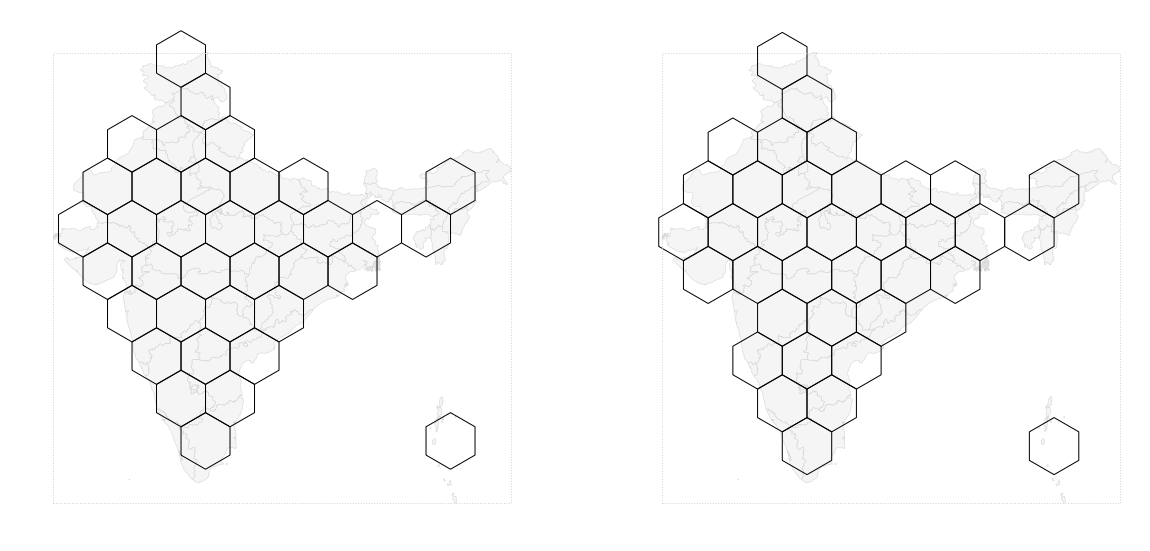

In [12]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
hexagons1.plot(ax=ax1, edgecolor='black', facecolor="none")
bbox_gdf.plot(ax=ax1, facecolor="none", edgecolor='lightgrey', linestyle=':')
#pt.plot(ax=ax1, color='red')

# Plot on axis 2 (left)
ax2.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax2, linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
hexagons2.plot(ax=ax2, edgecolor='black', facecolor="none")
bbox_gdf.plot(ax=ax2, facecolor="none", edgecolor='lightgrey', linestyle=':')

plt.show()

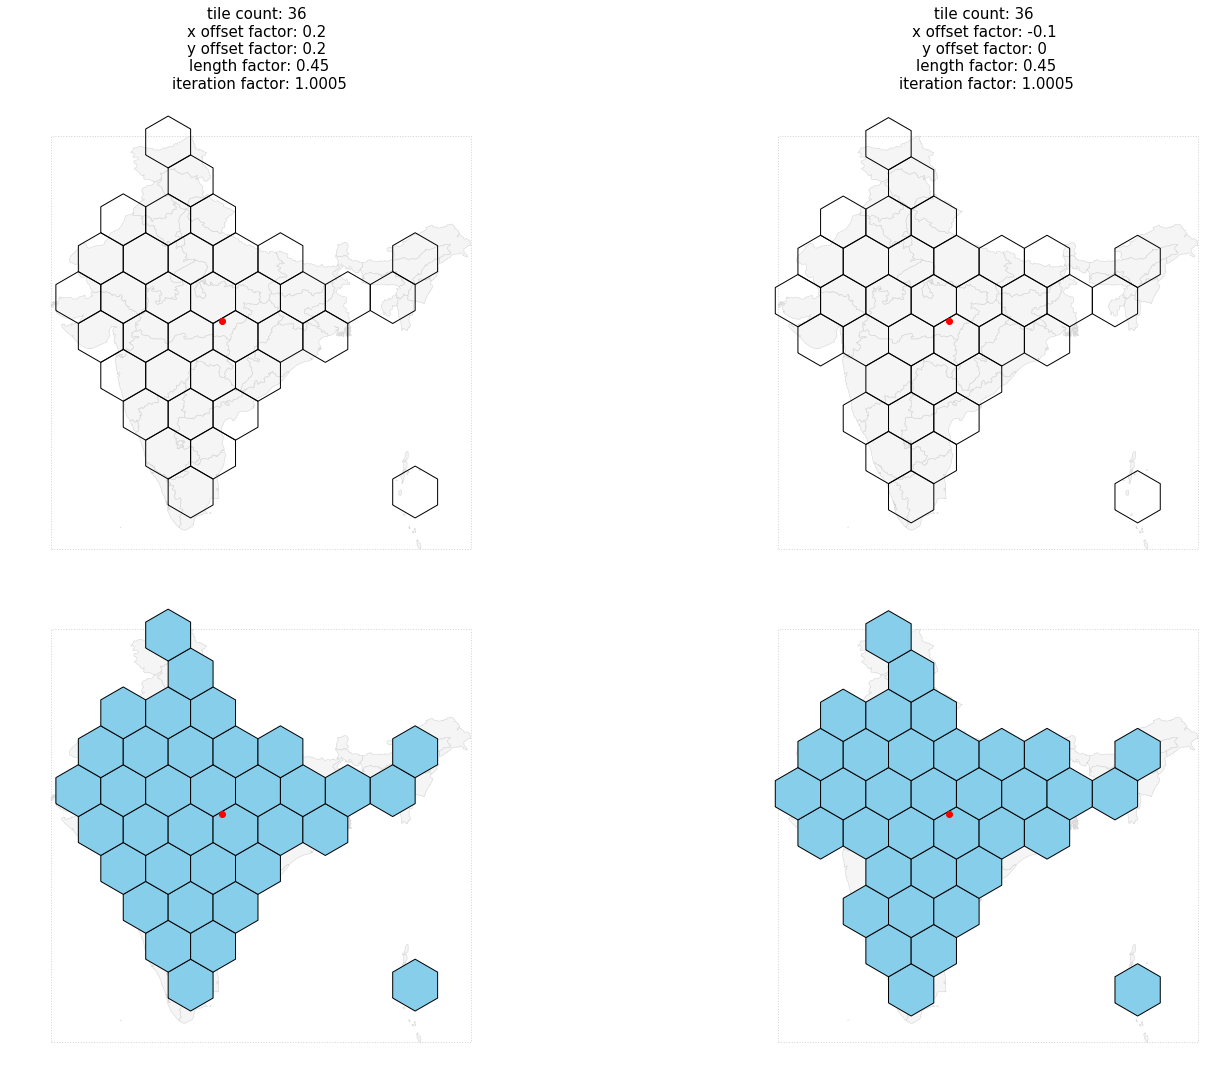

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(20, 15), sharex=True, sharey=True)

# Plot on axis 1 (top left)
ax[0,0].set_title('tile count: {} \nx offset factor: {} \ny offset factor: {} \nlength factor: {}\niteration factor: {}'.format(len(hexagons1), xofac1, yofac1, lfac, ifac), 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax[0,0].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[0,0], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[0,0], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax[0,0], edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[0,0], color='red')
admin.loc[admin[admin_id] == 'ME'].set_geometry('geom_centroid').plot(ax=ax[0,0], color='black')

# Plot on axis 2 (top right)
ax[0,1].set_title('tile count: {} \nx offset factor: {} \ny offset factor: {} \nlength factor: {}\niteration factor: {}'.format(len(hexagons2), xofac2, yofac2, lfac, ifac), 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax[0,1].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[0,1], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[0,1], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons2.plot(ax=ax[0,1], edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[0,1], color='red')
admin.loc[admin[admin_id] == 'ME'].set_geometry('geom_centroid').plot(ax=ax[0,1], color='black')

# Plot on axis 3 (bottom left)
ax[1,0].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[1,0], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[1,0], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax[1,0], edgecolor='black', facecolor="skyblue")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[1,0], color='red')
admin.loc[admin[admin_id] == 'ME'].set_geometry('geom_centroid').plot(ax=ax[1,0], color='black')

# Plot on axis 4 (bottom right)
ax[1,1].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[1,1], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[1,1], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons2.plot(ax=ax[1,1], edgecolor='black', facecolor="skyblue")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[1,1], color='red')
admin.loc[admin[admin_id] == 'ME'].set_geometry('geom_centroid').plot(ax=ax[1,1], color='black')

plt.show()

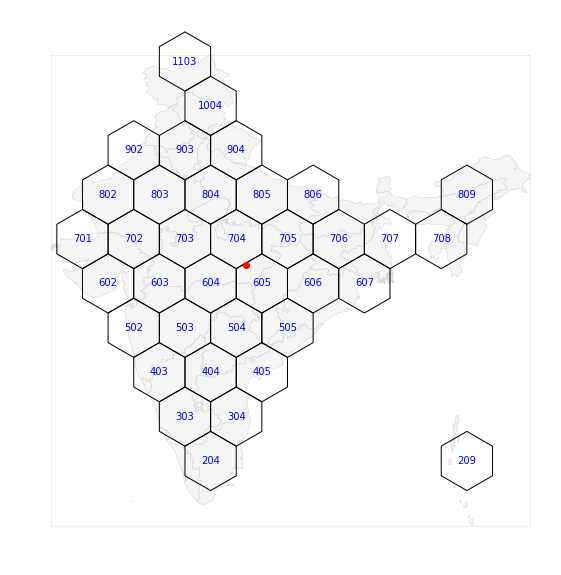

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax, edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax, color='red')
#hexagons1.set_geometry('geom_centroid').plot(ax=ax, color='lightblue')
#display_point_labels(admin.set_geometry('geom_centroid'), admin_id, c='black')
display_point_labels(hexagons1.set_geometry('geom_centroid'), tile_id)
admin.loc[admin[admin_id] == 'ME'].set_geometry('geom_centroid').plot(ax=ax, color='black')

#admin.set_geometry('geom_centroid').plot(ax=ax, color='green')

In [15]:
def dist_to_centroid_fld(centers, centroid, idx_col, order_col, sort_order):
    distances = {}
    print(type(centroid['geom_centroid']))
    centroid_pt = centroid['geom_centroid'][0] #Get Shapely point geom from geodataframe
    
    try:
        centers.drop(columns=['dist_to_centroid', order_col], inplace=True)
    except:
        pass
        
    for i, row in centers.iterrows():
        pt = row['geom_centroid']
        idx = row[idx_col] 
        distance = pt.distance(centroid_pt)
        distances[idx] = distance
        #print('{}  {}  {}'.format(i, idx, distance))
    
    if sort_order == 'farthest_first':
        rev = True
    elif sort_order == 'closest_first':
        rev = False
        
    distances_dict = dict(sorted(distances.items(), key=operator.itemgetter(1), 
                                 reverse=rev))
    distances_df = pd.DataFrame(list(distances_dict.items()), 
                                columns=[idx_col, 'dist_to_centroid'])
    distances_df[order_col] = distances_df.index
    centers = centers.join(distances_df.set_index(idx_col), 
                           on=idx_col).sort_values(by=[order_col]).reset_index(drop=True)

    return centers

def build_admin_tile_distance_df(admin_centers, tile_centers):
    cols = [admin_id, tile_id, 'distance']
    df_dist = pd.DataFrame(columns=cols, dtype=int)
    
    for idx1, admin_row in admin_centers.iterrows():
        admin_pt = admin_row['geom_centroid']
        admin_idx = admin_row[admin_id]
        
        for idx2, tile_row in tile_centers.iterrows():
            tile_pt = tile_row['geom_centroid']
            tile_idx = tile_row[tile_id]
            distance = tile_pt.distance(admin_pt)
            #print(distance)
            
            df_tmp = pd.DataFrame([[admin_idx, tile_idx, distance]], columns=cols)
            df_dist = df_dist.append(df_tmp, ignore_index=True)
            
    return df_dist

admin = dist_to_centroid_fld(admin, admin_hulls_dissolved, admin_id, jo_admin, 'farthest_first')
hexagons1 = dist_to_centroid_fld(hexagons1, admin_hulls_dissolved, tile_id, jo_tile, 'farthest_first')

#state_ctr = admin.loc[admin[admin_id] == 'ME'].set_geometry('geom_centroid').reset_index(drop=True)

#admin = dist_to_centroid_fld(admin, state_ctr,admin_id, jo_admin, 'closest_first')
#hexagons1 = dist_to_centroid_fld(hexagons1, state_ctr, tile_id, jo_tile, 'closest_first')
distance_df = build_admin_tile_distance_df(admin, hexagons1)

display(HTML(admin[[admin_id, jo_admin]].head(10).to_html()))
display(HTML(hexagons1[[tile_id, jo_tile]].head(10).to_html()))
display(HTML(distance_df.head(50).to_html()))

# display(HTML(admin.head(10).to_html()))
# display(HTML(hexagons1.head(5).to_html()))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


,admin_id,join_order_admin
0,ANDAMAN,0
1,LAKSHADWEEP,1
2,ARUNÄCHAL,2
3,NÄGÄLAND,3
4,MANIPUR,4
5,ASSAM,5
6,KERALA,6
7,MIZORAM,7
8,TAMIL,8
9,TRIPURA,9


,tile_id,join_order_tile
0,209,0
1,809,1
2,1103,2
3,204,3
4,708,4
5,701,5
6,1004,6
7,303,7
8,902,8
9,802,9


,admin_id,tile_id,distance
0,ANDAMAN,209.0,0.757217
1,ANDAMAN,809.0,15.745115
2,ANDAMAN,1103.0,29.059187
3,ANDAMAN,204.0,15.049800
4,ANDAMAN,708.0,13.067277
5,ANDAMAN,701.0,26.303659
6,ANDAMAN,1004.0,25.948530
7,ANDAMAN,303.0,16.749842
8,ANDAMAN,902.0,27.002647
9,ANDAMAN,802.0,26.471845


In [16]:
def match_one_to_another(admin_centers, tile_centers, dist_df, order_defined_by): 
    if order_defined_by == 'admin':
        cols = [admin_id_admin, tile_id]
        df_match = pd.DataFrame(columns=cols, dtype=int)
        
        for i, row in admin_centers[[admin_id, jo_admin]].iterrows():
            admin_idx = row[admin_id]
            df = dist_df.loc[dist_df[admin_id] == admin_idx]
            tile_idx = df.loc[df.groupby(admin_id)['distance'].idxmin()][tile_id].values[0]
            dist_df = dist_df[dist_df[tile_id] != tile_idx]

            df_tmp = pd.DataFrame([[admin_idx, tile_idx]], columns=cols)
            df_match = df_match.append(df_tmp, ignore_index=True)
    
    if order_defined_by == 'tile':
        cols = [admin_id_tile, tile_id]
        df_match = pd.DataFrame(columns=cols, dtype=int)
        
        for i, row in tile_centers[[tile_id, jo_tile]].iterrows():
            tile_idx = row[tile_id]
            df = dist_df.loc[dist_df[tile_id] == tile_idx]
            admin_idx = df.loc[df.groupby(tile_id)['distance'].idxmin()][admin_id].values[0]
            dist_df = dist_df[dist_df[admin_id] != admin_idx]

            df_tmp = pd.DataFrame([[admin_idx, tile_idx]], columns=cols)
            df_match = df_match.append(df_tmp, ignore_index=True)
            
    return df_match
    
farthest_states_match = match_one_to_another(admin, hexagons1, distance_df, 'admin')
farthest_tile_match = match_one_to_another(admin, hexagons1, distance_df, 'tile')

display(HTML(farthest_states_match.head(5).to_html()))
display(HTML(farthest_tile_match.head(5).to_html()))

hexagons1 = hexagons1.merge(farthest_states_match, on=tile_id)
hexagons1 = hexagons1.merge(farthest_tile_match, on=tile_id)

display(HTML(hexagons1.head(5).to_html()))

,admin_id_admin,tile_id
0,ANDAMAN,209.0
1,LAKSHADWEEP,204.0
2,ARUNÄCHAL,809.0
3,NÄGÄLAND,708.0
4,MANIPUR,707.0


,admin_id_tile,tile_id
0,ANDAMAN,209.0
1,ASSAM,809.0
2,JAMMU,1103.0
3,TAMIL,204.0
4,TRIPURA,708.0


,geom_poly,tile_id,geom_centroid,dist_to_centroid,join_order_tile,admin_id_admin,admin_id_tile
0,"POLYGON ((91.97062366687268 9.84303452795432, ...",209,POINT (93.53220255059144 10.74461251680941),17.972284,0,ANDAMAN,ANDAMAN
1,"POLYGON ((91.97062366687268 26.07143832706543,...",809,POINT (93.53220255059144 26.97301631592052),14.115880,1,ARUNÄCHAL,ASSAM
2,"POLYGON ((74.79325594665897 34.18564022662099,...",1103,POINT (76.35483483037773 35.08721821547608),12.964818,2,JAMMU,JAMMU
3,"POLYGON ((76.35483483031477 9.84303452795432, ...",204,POINT (77.91641371403354 10.74461251680941),12.122838,3,LAKSHADWEEP,TAMIL
4,"POLYGON ((90.40904478321688 23.36670436054692,...",708,POINT (91.97062366693564 24.268282349402),11.989727,4,NÄGÄLAND,TRIPURA


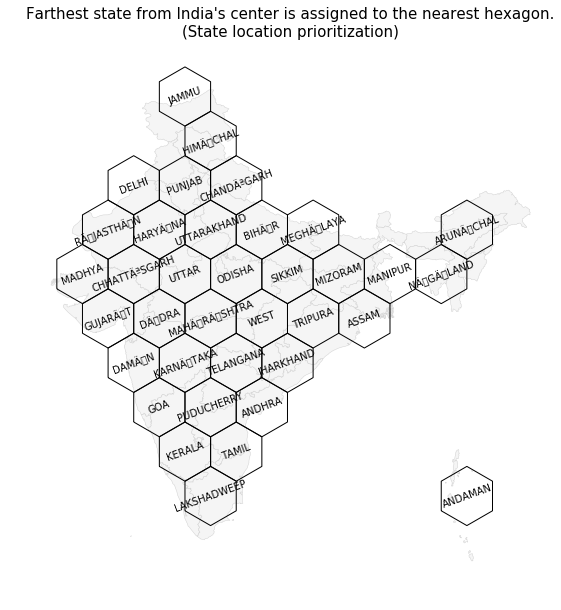

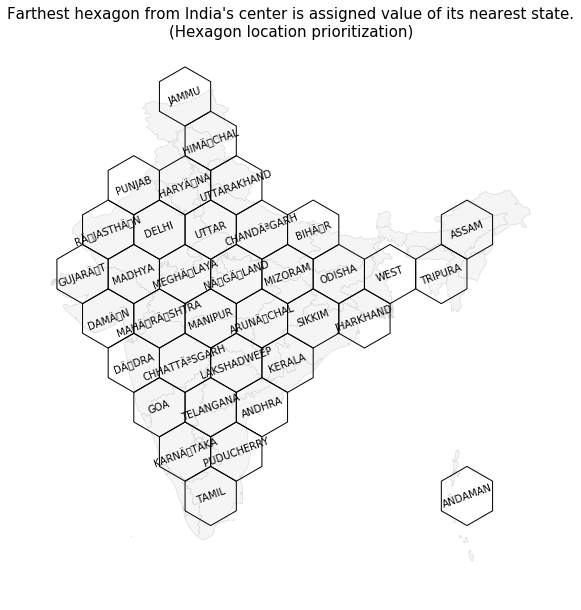

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 10))
ax.set_title('Farthest state from India\'s center is assigned to the nearest hexagon.\n(State location prioritization)', 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
#bbox_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax, edgecolor='black', facecolor="none")
hexagons1[tile_id] = hexagons1.index
display_point_labels(hexagons1.set_geometry('geom_centroid'), admin_id_admin, c='black', angle=20)


fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(11, 10))
ax2.set_title('Farthest hexagon from India\'s center is assigned value of its nearest state.\n(Hexagon location prioritization)', 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax2.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax2, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
#bbox_gdf.plot(ax=ax2, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax2, edgecolor='black', facecolor="none")
hexagons1[tile_id] = hexagons1.index
display_point_labels(hexagons1.set_geometry('geom_centroid'), admin_id_tile, c='black', angle=20)

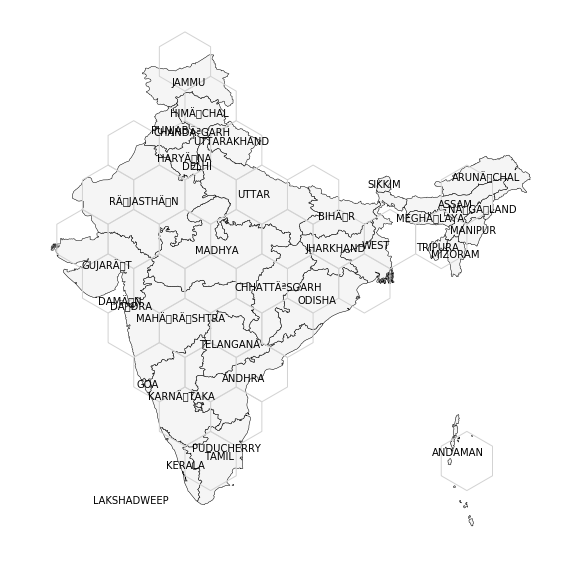

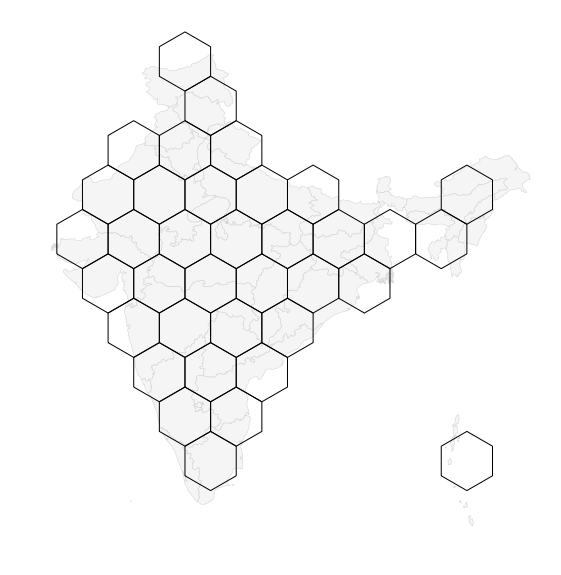

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
#ax.set_title('States', 
#                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax, linewidth=0.5, 
                                     edgecolor='black', color='whitesmoke')
#bbox_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax, edgecolor='lightgrey', facecolor="none")
hexagons1[tile_id] = hexagons1.index
display_point_labels(admin.set_geometry('geom_centroid'), admin_id, c='black')



fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
#ax2.set_title('Blank', 
#                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax2.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax2, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
#bbox_gdf.plot(ax=ax2, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax2, edgecolor='black', facecolor="none")
hexagons1[tile_id] = hexagons1.index

In [19]:
#hexagons1.drop(columns=['geom_centroid']).to_file('USA_hexagons.geojson', driver='GeoJSON')